The proposed approach is a variation of mean shift clustering that allows for fast computation.

In [180]:
import numpy as np
import scipy.stats as st

class FastDensityClustering():
    @staticmethod
    def gaussian_kernel(size=21, nsig=3):
        """Returns a 2D Gaussian kernel.
        Args:
            size: The size of the kernel (size x size)
            nsig: Sigma of the gaussian
        """
        x = np.linspace(-nsig, nsig, size+1)
        kern1d = np.diff(st.norm.cdf(x))
        kern2d = np.outer(kern1d, kern1d)
        return kern2d/kern2d.sum()
    
    @staticmethod
    def density_from_coordinates(coords, shape = [200,200]):
        coords[0] = coords[0]-np.min(coords[0])
        coords[1] = coords[1]-np.min(coords[1])
        coords[0] = coords[0]/np.max(coords[0])
        coords[1] = coords[1]/np.max(coords[1])
        density = np.zeros(shape=shape)
        for y,x in zip(coords[0],coords[1]):
            y*= shape[0]
            x*= shape[1]

            y = int(y)
            x = int(x)

            density[y-1,x-1] += 1
        return density

    @staticmethod
    def kernel(size, ktype):
        """ Returns a kernel of specified size and type
        Args:
            size: Kernel size
            ktype: Type of kernel. Either uniform gaussian or disk are provided.
        """
        if ktype == "uniform":
            return np.ones((size,size))
        elif ktype == "gaussian":
            k = FastDensityClustering.gaussian_kernel(size=size)
            k /= np.max(k)
            return k
        elif ktype == "disk":
            k = FastDensityClustering.gaussian_kernel(size=size)
            k /= np.max(k)
            return k > 0.03

    @staticmethod
    def collapse_iteration(arr,kernel, labels=None):
        """ Determins center of gravity for each non-zero (forground pixel) and it's surround weighted by the kernel
            and increases mass at named target position/pixel by the mass of the source pixel.
        Args:
            arr: Grayscale array of positive values where value zero stands for the background and positive values denote the mass for a given foreground pixel.
            kernel: Kernel used to weight the influance of nearby pixels in computing the center of mass
        """
        kernel_width = kernel.shape[0]
        kernel_height = kernel.shape[1]
        ys, xs = np.where(arr>0)
        new = np.zeros(arr.shape)
        abs_shift = 0

        for y, x in zip(ys,xs):
            snippet = arr[y-kernel_width//2:(y+kernel_width//2)+1, x-kernel_width//2:(x+kernel_width//2)+1]

            snippet = kernel * snippet
            weights_x = np.mean(snippet,axis=0)
            weights_y = np.mean(snippet,axis=1)

            shift_x = np.average(np.arange(kernel_width),weights=weights_x)#The inner mean returns x values, the outer is their mean -> shift x
            shift_y = np.average(np.arange(kernel_height),weights=weights_y)#The inner mean returns y values, the outer is their mean -> shift y
            shift_x -= (kernel_width-1)/2
            shift_y -= (kernel_height-1)/2


            y1 = int(y+shift_y)
            x1 = int(x+shift_x)

            abs_shift += np.abs(shift_x) + np.abs(shift_y)
            new[y1,x1] += arr[y,x]
            if type(labels) != type(None):
                if y1 != y or x1 != x:
                    new_list = []
                    new_list.extend(labels[y1,x1])
                    new_list.extend(labels[y,x])

                    labels[y1,x1] = new_list
                    labels[y,x] = []
                

        return new, abs_shift/len(xs), labels

    @staticmethod
    def collapse(arr, iterations = None,gravity_type="uniform", gravity_size=5, labels=True):
        """ Performs clustering by iteratively moving all mass densities (non-zero/foreground pixels) to their center of mass.
        If no value for iterations is specified the algorithm runs until convergence is achieved and the movement is marginally.
        Args:
            arr: Array of positive gray values
            iterations: Number of iterations. If no value for iterations is specified the algorithm runs until convergence is achieved.
            gravity_type: Either "uniform", "gaussian" or "disk". The contributions to the center of mass for one pixels by its surround are weighted accordingly.
            gravity_size: The size of the gravity kernel.
        Returns:
            Array representation of cluster centers. Each cluster center is represented by a non-zero pixel.
        """
        epsilon = None
        if not iterations:
            iterations = 100000
            epsilon = 1.0e-16

        if gravity_size % 2 == 0:
            gravity_size += 1
        k = FastDensityClustering.kernel(gravity_size,gravity_type)
        arr = np.pad(arr,gravity_size, "constant")
        
        if not labels:
            labels = None
        else:
            labels = np.ndarray(arr.shape, dtype=object)
            labels.fill([])
            ys, xs = np.where(arr>0)
            for y, x in zip(ys,xs):
                labels[y,x] = [[y-gravity_size,x-gravity_size]]
            
        for x in range(iterations):
            arr, shift, labels = FastDensityClustering.collapse_iteration(arr,k, labels)
            if epsilon:
                if epsilon > shift:
                    break
                    
        labels = np.array(labels[gravity_size:-gravity_size,gravity_size:-gravity_size])
        return arr[gravity_size:-gravity_size,gravity_size:-gravity_size], labels

    @staticmethod
    def density_clustering(arr, iterations = None,gravity_type="uniform", gravity_size=5):
        """ Performs clustering by iteratively moving all mass densities (non-zero/foreground pixels) to their center of mass.
        If no value for iterations is specified the algorithm runs until convergence is achieved and the movement is marginally.
        Args:
            arr: Array of positive gray values
            iterations: Number of iterations. If no value for iterations is specified the algorithm runs until convergence is achieved.
            gravity_type: Either "uniform", "gaussian" or "disk". The contributions to the center of mass for one pixels by its surround are weighted accordingly.
            gravity_size: The size of the gravity kernel.
        Returns:
            Y and x positions of all detected cluster centers
        """
        cluster_array, raw_labels = FastDensityClustering.collapse(arr,iterations,gravity_type=gravity_type, gravity_size=gravity_size)
        center_y,center_x = np.where(cluster_array>0)
        labels = np.zeros(cluster_array.shape)
        for i in range(0,len(center_y)):
            m = np.array(raw_labels[center_y[i],center_x[i]])
            labels[m[:,0],m[:,1]] = i
            center_y[i] = np.mean(m[:,0])
            center_x[i] = np.mean(m[:,1])

        return center_y, center_x, cluster_array, labels


In [181]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def get_coords(n_centers = 10):
    features, target = make_blobs(n_samples = 50 * n_centers, n_features = 2, 
                                    centers = n_centers, cluster_std = 5/n_centers, shuffle = True)
    coords = np.array([features[:,0],features[:,1]])
    return coords


In [182]:
def points_and_background(img, x,y, point_size=5, marker ="x"):
    """ Prints samled points in front of image
    Args:
        img: Image as numpy array
        x: Vector of x positions
        y: Vector of y positions

    """
    fig, ax = plt.subplots(1, figsize=(12,10))

    ax.set_xlim((0, img.shape[1]))
    ax.set_ylim((img.shape[0], 0))
    ax.imshow(img,cmap="gray")
    ax.scatter(x,y, s=point_size,c="red",marker=marker)

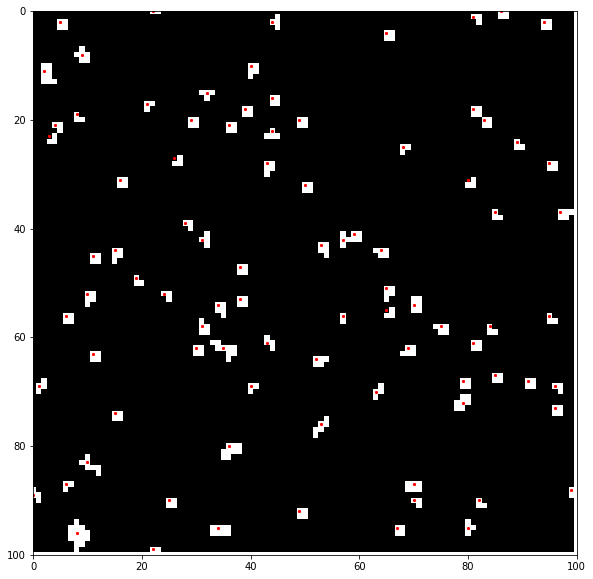

In [190]:
density = FastDensityClustering.density_from_coordinates(get_coords(100),shape=[100,100])>0
center_y, center_x, cluster_array, labels = FastDensityClustering.density_clustering(density, gravity_size=2)

points_and_background(density,center_x,center_y)

In [191]:
#plt.imshow(np.array([[len(m) for m in map] for map in mappings]))

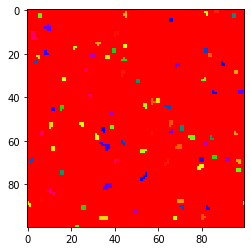

In [192]:
plt.imshow(labels[:], cmap="prism")

In [130]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [131]:
import timeit

In [132]:
d = None
n_points = []
time = []

def experiment():
    global d
    FastDensityClustering.density_clustering(d)

def evaluate(n_cluster_centers,repetitions = 5):
    global d
    global n_points
    global time
    n_points = []
    time = []
    for n in n_cluster_centers:
        d = FastDensityClustering.density_from_coordinates(get_coords(n),shape=[n,n])>0
        t = np.mean(timeit.repeat("for x in range(5): experiment ()", "from __main__ import experiment", number=repetitions))/repetitions
        n_points.append(np.sum(d))
        time.append(np.sum(t))
        print(".", end="")
    return time, n_points

In [133]:
time, n_points = evaluate(list(range(10,250,10)))

........................

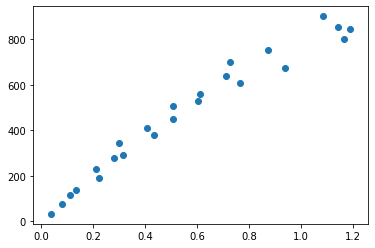

In [122]:
plt.scatter(time, n_points)